# This notebook is for the Fair-Shapely experiment

In [1]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [3]:
from src.data.unified_dataloader import load_dataset

a, processed_german_credit = load_dataset('german_credit')
# _, processed_uci = load_dataset('uci')

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64


In [4]:
processed_german_credit.head(3)

,Age,sex,Credit amount,Duration,Job_0,Job_1,Job_2,Job_3,Housing_free,Housing_own,...,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk
0,2.766456,0,-0.745131,-1.236478,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,-1.191404,1,0.949817,2.248194,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
2,1.183312,0,-0.416562,-0.738668,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


### 3. Split label/unlabel data, split train/test data.

In [5]:
'''UCI dataset'''
# df = processed_uci.copy()
# X = df.drop('income', axis=1)
# y = df['income']

'''German Credit dataset'''
df = processed_german_credit.copy()
X = df.drop('Risk', axis=1)
y = df['Risk']


In [6]:
from src.evaluation.five_fold_cross_validation import evaluate_model
model = XGBClassifier()
evaluate_model(model=model, X_train=X, y_train=y, num_folds=5, dataset_name='german_credit', fairshap_base='DR')

c:\Users\ZhuLi\Anaconda3\envs\unlabel_fair\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-------------------------------------
-------------1th fold----------------
-------------------------------------
1. Split the german_credit dataset into majority group and minority group according to the number of sensitive attribute, besides split by label 0 and label 1
X_train_majority_label0 shape: (391, 26)
X_train_majority_label1 shape: (152, 26)
X_train_minority_label0 shape: (168, 26)
X_train_minority_label1 shape: (89, 26)
2. 初始化FairnessExplainer
--------接下来先对minority group进行修改--------
3(a). 将X_train_minority_label0与X_train_majority_label0进行匹配
3(b). 将X_train_minority_label1与X_train_majority_label1进行匹配
4(a). 使用FairSHAP, 从 X_train_majority_label0中找到合适的值替换X_train_minority_label0中的数据
4(b). 使用FairSHAP, 从 X_train_majority_label1中找到合适的值替换X_train_minority_label1中的数据
5. 计算出varphi和q
在X_train_minority中shapely value中大于0.1的值的个数有: 31
--------接下来对majority group进行修改--------
3(a). 将X_train_majority_label0与X_train_minority_label0进行匹配
3(b). 将X_train_majority_label1与X_train_minority_label1进行匹配
4(

### 4. read saved_csv file and make plots --- 2025/3/10 FairSHAP(DR), threshold=0.1

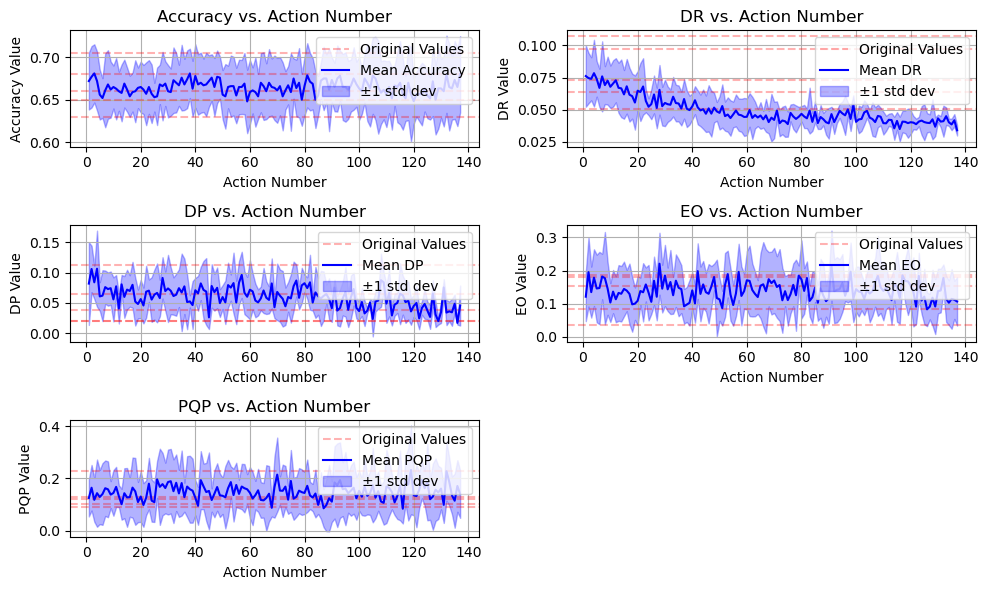

In [ ]:
import pandas as pd
import numpy as np
from src.visualization.visualization2 import plot_results

def extract_original_values(fold):
    original_accuracy = fold.loc[0, 'new_accuracy']
    original_DR = fold.loc[0, 'new_DR']
    original_DP = fold.loc[0, 'new_DP']
    original_EO = fold.loc[0, 'new_EO']
    original_PQP = fold.loc[0, 'new_PQP']
    # original_recall = fold.loc[0, 'new_recall']
    # original_precision = fold.loc[0, 'new_precision']
    # original_sufficiency = fold.loc[0, 'new_sufficiency']
    return original_accuracy, original_DR, original_DP, original_EO, original_PQP

fold1 = pd.read_csv('saved_results/german_credit/fairSHAP-DR_1-fold_results.csv')
fold2 = pd.read_csv('saved_results/german_credit/fairSHAP-DR_2-fold_results.csv')
fold3 = pd.read_csv('saved_results/german_credit/fairSHAP-DR_3-fold_results.csv')
fold4 = pd.read_csv('saved_results/german_credit/fairSHAP-DR_4-fold_results.csv')
fold5 = pd.read_csv('saved_results/german_credit/fairSHAP-DR_5-fold_results.csv')

fold1_original_values = extract_original_values(fold1)
fold2_original_values = extract_original_values(fold2)
fold3_original_values = extract_original_values(fold3)
fold4_original_values = extract_original_values(fold4)
fold5_original_values = extract_original_values(fold5)

fold1.drop(fold1.index[0], inplace=True)
fold2.drop(fold2.index[0], inplace=True)
fold3.drop(fold3.index[0], inplace=True)
fold4.drop(fold4.index[0], inplace=True)
fold5.drop(fold5.index[0], inplace=True)

folds = [fold1, fold2, fold3, fold4, fold5]
original_accuracy = [fold1_original_values[0], fold2_original_values[0], fold3_original_values[0], fold4_original_values[0], fold5_original_values[0]]
original_drs = [fold1_original_values[1], fold2_original_values[1], fold3_original_values[1], fold4_original_values[1], fold5_original_values[1]]
original_dps = [fold1_original_values[2], fold2_original_values[2], fold3_original_values[2], fold4_original_values[2], fold5_original_values[2]]
original_eos = [fold1_original_values[3], fold2_original_values[3], fold3_original_values[3], fold4_original_values[3], fold5_original_values[3]]
original_pqps = [fold1_original_values[4], fold2_original_values[4], fold3_original_values[4], fold4_original_values[4], fold5_original_values[4]]
# original_recalls = [fold1_original_values[4], fold2_original_values[4], fold3_original_values[4], fold4_original_values[4], fold5_original_values[4]]
# original_precisions = [fold1_original_values[5], fold2_original_values[5], fold3_original_values[5], fold4_original_values[5], fold5_original_values[5]]
# original_sufficiencies = [fold1_original_values[6], fold2_original_values[6], fold3_original_values[6], fold4_original_values[6], fold5_original_values[6]]

# 调用函数
plot_results(
    folds=folds,
    original_accuracy=original_accuracy,
    original_DR=original_drs, 
    original_DP=original_dps, 
    original_EO=original_eos, 
    original_PQP=original_pqps,
    stop_when_no_data=3,
    min_action=1,
    figsize=(10, 6),
    fill_alpha=0.3,
    fill_color='b',
    red_alpha=0.3  # 红线透明度
)

In [25]:
fold_last_rows = [
    fold1.iloc[-1], 
    fold2.iloc[-1], 
    fold3.iloc[-1], 
    fold4.iloc[-1], 
    fold5.iloc[-1]
]

# 转换为 DataFrame 以便计算均值和标准差
df_last_rows = pd.DataFrame(fold_last_rows)

# 计算每列的 mean 和 std
mean_values = df_last_rows.mean()
std_values = df_last_rows.std()

# 组合成新的 DataFrame，显示 "mean ± std" 形式
result_df = pd.DataFrame({
    "Mean": mean_values,
    "Std": std_values,
    "Mean ± Std": mean_values.round(4).astype(str) + " ± " + std_values.round(4).astype(str)
})
result_df

,Mean,Std,Mean ± Std
action_number,125.200000,41.990475,125.2 ± 41.9905
new_accuracy,0.663000,0.046717,0.663 ± 0.0467
new_DR,0.033040,0.002890,0.033 ± 0.0029
new_DP,0.051218,0.033691,0.0512 ± 0.0337
new_EO,0.119271,0.086793,0.1193 ± 0.0868
new_PQP,0.115617,0.076845,0.1156 ± 0.0768


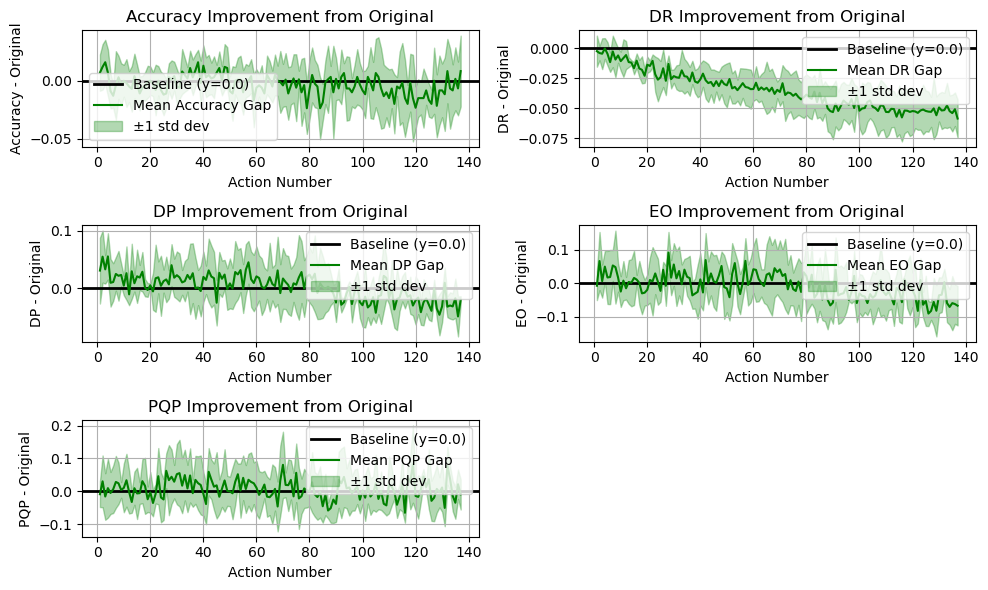

In [ ]:
from src.visualization.visualization1 import plot_fairness_improvement

plot_fairness_improvement(
    folds=folds,
    original_accuracy=original_accuracy,
    original_DR=original_drs,
    original_DP=original_dps,
    original_EO=original_eos,
    original_PQP=original_pqps,
    stop_when_no_data=3,  # 当有 3 个 fold 无数据时停止
    min_action=1,
    baseline=0.0,
    figsize=(10, 6),
    fill_alpha=0.3,
    fill_color='g'
)

-------------------------------------------------------------

### 4.3 DP  ----- 2025/3/1

In [ ]:
import pandas as pd
import numpy as np

def extract_original_values(fold):
    original_DR = fold.loc[0, 'new_DR']
    original_DP = fold.loc[0, 'new_DP']
    original_EO = fold.loc[0, 'new_EO']
    original_PQP = fold.loc[0, 'new_PQP']
    original_recall = fold.loc[0, 'new_recall']
    original_precision = fold.loc[0, 'new_precision']
    original_sufficiency = fold.loc[0, 'new_sufficiency']
    return original_DR, original_DP, original_EO, original_PQP, original_recall, original_precision, original_sufficiency

fold1 = pd.read_csv('saved_results/german_credit/fairSHAP-DP_1-fold_results.csv')
fold2 = pd.read_csv('saved_results/german_credit/fairSHAP-DP_2-fold_results.csv')
fold3 = pd.read_csv('saved_results/german_credit/fairSHAP-DP_3-fold_results.csv')
fold4 = pd.read_csv('saved_results/german_credit/fairSHAP-DP_4-fold_results.csv')
fold5 = pd.read_csv('saved_results/german_credit/fairSHAP-DP_5-fold_results.csv')

fold1_original_values = extract_original_values(fold1)
fold2_original_values = extract_original_values(fold2)
fold3_original_values = extract_original_values(fold3)
fold4_original_values = extract_original_values(fold4)
fold5_original_values = extract_original_values(fold5)

fold1.drop(fold1.index[0], inplace=True)
fold2.drop(fold2.index[0], inplace=True)
fold3.drop(fold3.index[0], inplace=True)
fold4.drop(fold4.index[0], inplace=True)
fold5.drop(fold5.index[0], inplace=True)

folds = [fold1, fold2, fold3, fold4, fold5]
original_drs = [fold1_original_values[0], fold2_original_values[0], fold3_original_values[0], fold4_original_values[0], fold5_original_values[0]]
original_dps = [fold1_original_values[1], fold2_original_values[1], fold3_original_values[1], fold4_original_values[1], fold5_original_values[1]]
original_eos = [fold1_original_values[2], fold2_original_values[2], fold3_original_values[2], fold4_original_values[2], fold5_original_values[2]]
original_pqps = [fold1_original_values[3], fold2_original_values[3], fold3_original_values[3], fold4_original_values[3], fold5_original_values[3]]
original_recalls = [fold1_original_values[4], fold2_original_values[4], fold3_original_values[4], fold4_original_values[4], fold5_original_values[4]]
original_precisions = [fold1_original_values[5], fold2_original_values[5], fold3_original_values[5], fold4_original_values[5], fold5_original_values[5]]
original_sufficiencies = [fold1_original_values[6], fold2_original_values[6], fold3_original_values[6], fold4_original_values[6], fold5_original_values[6]]

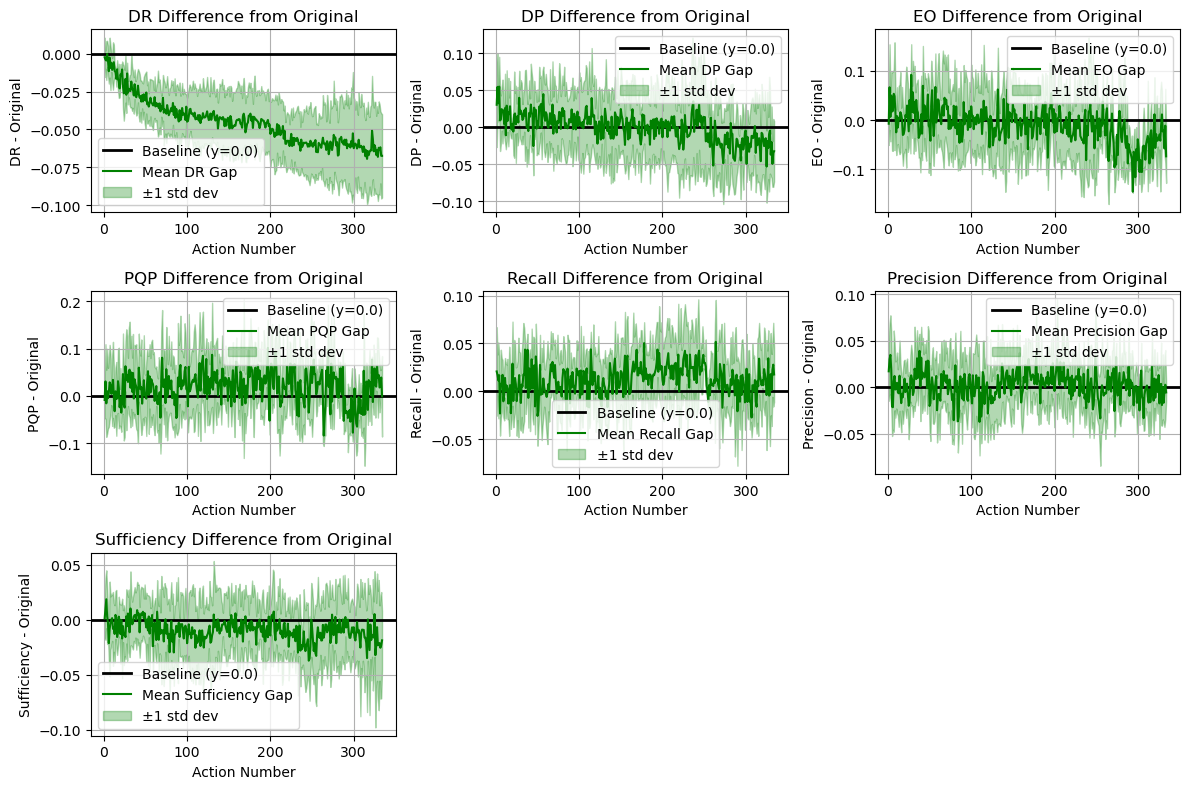

In [8]:
from src.visualization.viz3 import plot_fairness_improvement
# 调用函数
plot_fairness_improvement(
    folds=folds,
    original_DR=original_drs, 
    original_DP=original_dps, 
    original_EO=original_eos, 
    original_PQP=original_pqps,
    original_recall=original_recalls,
    original_precision=original_precisions,
    original_sufficiency=original_sufficiencies,
    stop_when_no_data=3,
    min_action=1,
    figsize=(12, 8),
    fill_alpha=0.3,
    fill_color='g',
    # red_alpha=0.3  # 红线透明度
)

### 4.3 EO

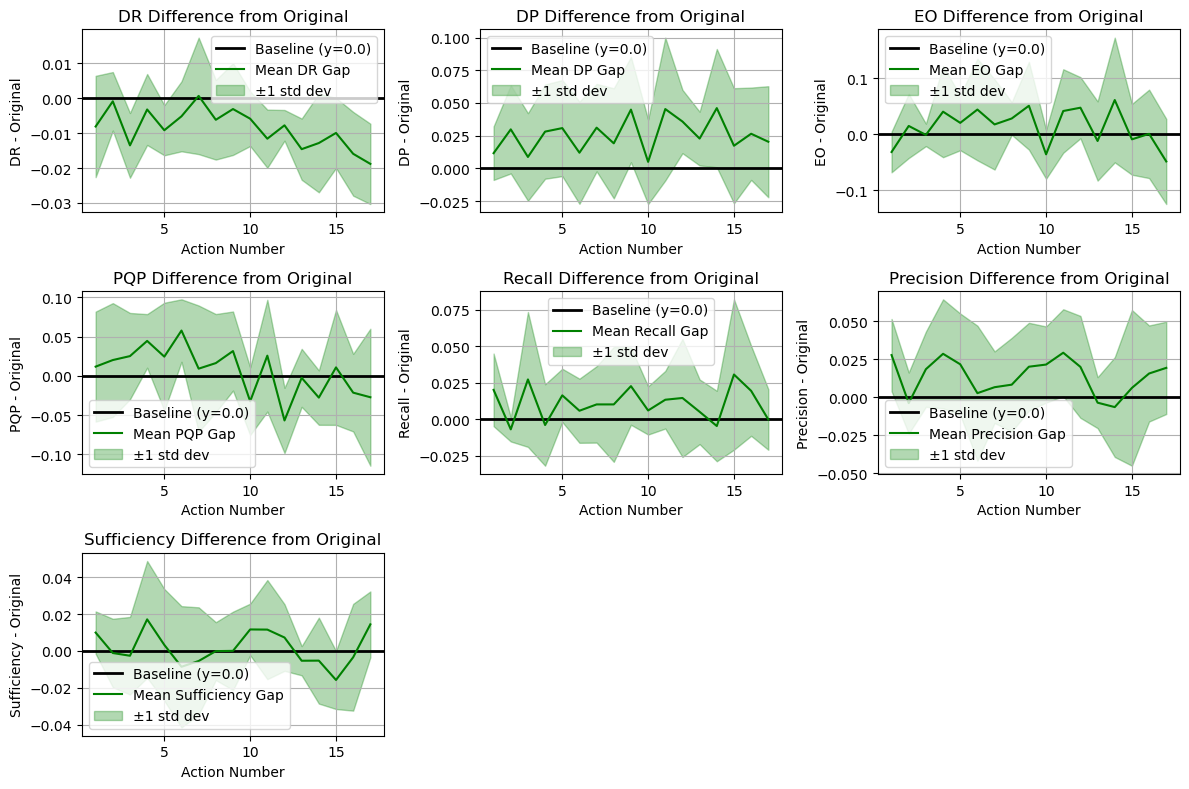

In [15]:
import pandas as pd
import numpy as np

def extract_original_values(fold):
    original_DR = fold.loc[0, 'new_DR']
    original_DP = fold.loc[0, 'new_DP']
    original_EO = fold.loc[0, 'new_EO']
    original_PQP = fold.loc[0, 'new_PQP']
    original_recall = fold.loc[0, 'new_recall']
    original_precision = fold.loc[0, 'new_precision']
    original_sufficiency = fold.loc[0, 'new_sufficiency']
    return original_DR, original_DP, original_EO, original_PQP, original_recall, original_precision, original_sufficiency

fold1 = pd.read_csv('saved_results/german_credit/fairSHAP-EO_1-fold_results.csv')
fold2 = pd.read_csv('saved_results/german_credit/fairSHAP-EO_2-fold_results.csv')
fold3 = pd.read_csv('saved_results/german_credit/fairSHAP-EO_3-fold_results.csv')
fold4 = pd.read_csv('saved_results/german_credit/fairSHAP-EO_4-fold_results.csv')
fold5 = pd.read_csv('saved_results/german_credit/fairSHAP-EO_5-fold_results.csv')

fold1_original_values = extract_original_values(fold1)
fold2_original_values = extract_original_values(fold2)
fold3_original_values = extract_original_values(fold3)
fold4_original_values = extract_original_values(fold4)
fold5_original_values = extract_original_values(fold5)

fold1.drop(fold1.index[0], inplace=True)
fold2.drop(fold2.index[0], inplace=True)
fold3.drop(fold3.index[0], inplace=True)
fold4.drop(fold4.index[0], inplace=True)
fold5.drop(fold5.index[0], inplace=True)

folds = [fold1, fold2, fold3, fold4, fold5]
original_drs = [fold1_original_values[0], fold2_original_values[0], fold3_original_values[0], fold4_original_values[0], fold5_original_values[0]]
original_dps = [fold1_original_values[1], fold2_original_values[1], fold3_original_values[1], fold4_original_values[1], fold5_original_values[1]]
original_eos = [fold1_original_values[2], fold2_original_values[2], fold3_original_values[2], fold4_original_values[2], fold5_original_values[2]]
original_pqps = [fold1_original_values[3], fold2_original_values[3], fold3_original_values[3], fold4_original_values[3], fold5_original_values[3]]
original_recalls = [fold1_original_values[4], fold2_original_values[4], fold3_original_values[4], fold4_original_values[4], fold5_original_values[4]]
original_precisions = [fold1_original_values[5], fold2_original_values[5], fold3_original_values[5], fold4_original_values[5], fold5_original_values[5]]
original_sufficiencies = [fold1_original_values[6], fold2_original_values[6], fold3_original_values[6], fold4_original_values[6], fold5_original_values[6]]


from src.visualization.viz3 import plot_fairness_improvement
# 调用函数
plot_fairness_improvement(
    folds=folds,
    original_DR=original_drs, 
    original_DP=original_dps, 
    original_EO=original_eos, 
    original_PQP=original_pqps,
    original_recall=original_recalls,
    original_precision=original_precisions,
    original_sufficiency=original_sufficiencies,
    stop_when_no_data=3,
    min_action=1,
    figsize=(12, 8),
    fill_alpha=0.3,
    fill_color='g',

)
